In [1]:
import numpy as np
import pandas as pd
import jieba
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head(1)

,id,content,location_traffic_convenience,location_distance_from_business_district,location_easy_to_find,service_wait_time,service_waiters_attitude,service_parking_convenience,service_serving_speed,price_level,...,environment_decoration,environment_noise,environment_space,environment_cleaness,dish_portion,dish_taste,dish_look,dish_recommendation,others_overall_experience,others_willing_to_consume_again
0,0,"""吼吼吼，萌死人的棒棒糖，中了大众点评的霸王餐，太可爱了。一直就好奇这个棒棒糖是怎么个东西，...",-2,-2,-2,-2,1,-2,-2,-2,...,-2,-2,-2,-2,-2,-2,1,-2,1,-2


In [4]:
def get_dummies(data,name): return pd.get_dummies(data[name], prefix=name)

In [5]:
def handle_dummies(data):
    columns_names = data.columns.values[2:]
    
    concat_list = [data]
    
    for name in columns_names:
        concat_list.append(get_dummies(data, name))
        
    return pd.concat(concat_list, axis=1)

In [6]:
train =  handle_dummies(train).iloc[:40000]

In [7]:
train.shape

(40000, 102)

In [8]:
all_contents = train['content'].tolist()

In [9]:
def cut(string): return list(jieba.cut(string))

In [10]:
all_contents = [' '.join(cut(s)) for s in all_contents]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_8/f14fxxnn7w13cd0l5x9hl4bm0000gn/T/jieba.cache
Loading model cost 0.777 seconds.
Prefix dict has been built succesfully.


In [11]:
all_contents[0]

'" 吼吼 吼 ， 萌死 人 的 棒棒糖 ， 中 了 大众 点评 的 霸王餐 ， 太 可爱 了 。 一直 就 好奇 这个 棒棒糖 是 怎么 个 东西 ， 大众 点评 给 了 我 这个 土老冒 一个 见识 的 机会 。 看 介绍 棒棒糖 是 用 德国 糖 做 的 ， 不会 很甜 ， 中间 的 照片 是 糯米 的 ， 能 食用 ， 真是太 高端 大气 上档次 了 ， 还 可以 买 蝴蝶结 扎口 ， 送人 可以 买 礼盒 。 我 是 先 打 的 卖家 电话 ， 加 了 微信 ， 给 卖家 传 的 照片 。 等 了 几天 ， 卖家 就 告诉 我 可以 取货 了 ， 去 大官 屯 那取 的 。 虽然 连 卖家 的 面 都 没 见到 ， 但是 还是 谢谢 卖家 送 我 这么 可爱 的 东西 ， 太 喜欢 了 ， 这 哪 舍得吃 啊 。 "'

In [12]:
max_features = 10000
maxlen = 200
embed_size = 300

In [13]:
tokenizer = Tokenizer(num_words=max_features)

In [14]:
tokenizer.fit_on_texts(all_contents)

In [15]:
sequences = tokenizer.texts_to_sequences(all_contents)

In [16]:
X_train = pad_sequences(sequences, maxlen=maxlen)

In [17]:
y_train = train[train.columns[-80:]].values

In [18]:
from keras import backend as K

In [19]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [20]:
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, input_length=maxlen)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(80, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop', metrics=[fmeasure])
    return model

In [21]:
model = get_model()

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 160)     182880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [24]:
batch_size = 32
epochs = 3

In [25]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=0)

/anaconda3/envs/Kstone/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Train on 36000 samples, validate on 4000 samples
Epoch 1/3
 - 511s - loss: 0.3101 - fmeasure: 0.7305 - val_loss: 0.2624 - val_fmeasure: 0.7794
Epoch 2/3
 - 499s - loss: 0.2484 - fmeasure: 0.7934 - val_loss: 0.2382 - val_fmeasure: 0.8042
Epoch 3/3
 - 510s - loss: 0.2278 - fmeasure: 0.8133 - val_loss: 0.2257 - val_fmeasure: 0.8160


In [27]:
y_pred = model.predict(X_val, batch_size=batch_size)

In [28]:
y_pred.shape

(4000, 80)

In [29]:
y_pred[0]

array([0.98608506, 0.00422342, 0.00446591, 0.01070155, 0.94782794,
       0.00696616, 0.00674766, 0.0491019 , 0.9865493 , 0.01569372,
       0.01328971, 0.00507242, 0.34879437, 0.12149802, 0.17175905,
       0.35670638, 0.9631331 , 0.00889349, 0.03535378, 0.02443672,
       0.9982553 , 0.00123718, 0.00322242, 0.00128714, 0.95403504,
       0.03915981, 0.02017061, 0.01213323, 0.9370272 , 0.02383256,
       0.0351185 , 0.02651793, 0.9653683 , 0.0082753 , 0.0179084 ,
       0.01460921, 0.29853055, 0.0833416 , 0.5943354 , 0.05711766,
       0.12159055, 0.01734844, 0.07592147, 0.69108677, 0.10690734,
       0.02363618, 0.12229908, 0.74941844, 0.12181702, 0.03365564,
       0.08062563, 0.7271153 , 0.15552238, 0.02321894, 0.11829294,
       0.62044257, 0.8064472 , 0.06521443, 0.07551616, 0.05430367,
       0.02096891, 0.01072435, 0.74873406, 0.2142238 , 0.9182535 ,
       0.00921345, 0.03099818, 0.0564101 , 0.9274036 , 0.02765364,
       0.02295746, 0.02840749, 0.05033546, 0.01132453, 0.52504

In [30]:
import matplotlib.pyplot as plt

In [31]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

In [32]:
epochs = range(1, len(loss) + 1)

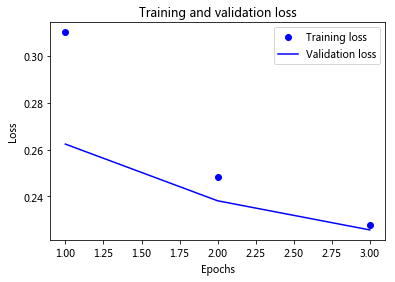

In [35]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
plt.clf()

<Figure size 432x288 with 0 Axes>